# TP: Image Reconstruction in X-Ray Tomography 

# I Introduction

X-ray tomography reconstructs dense volumes of objects from a set of projections measured at different angles. The measurements
$y\in\mathbb{R}^M$ and the sought absorption image $\overline{x}\in\mathbb{R}^N$ obey the linear relation
\begin{equation}
y = H \overline{x} + w,
\label{eq:tomo_problem}
\end{equation}
where $w \in \mathbb{R}^M$ is the measurement noise, that we assume i.i.d. Gaussian with variance $\sigma^2$. The tomography matrix $H \in \mathbb{R}^{M \times N}$ is sparse and encodes the geometry of the measurements. Here, we will focus on the case when $H$ models parallel projections of a 2-D
object $\overline{x}$. Tomography measures are acquired at fixed and regularly
sampled rotational positions between the sample and the detector so that
$H_{mn}$ models the intersection length between the $m$th light-ray and the
$n$th pixel. If $N_\theta$ is the number of different angular positions of the detector and $L$ the linear size of the detector, the number of measurements $M=L\times
N_\theta$. In practice, the angular positions are regularly distributed on
$[0,\pi)$.

Traditional reconstruction methods such as the Filtered Back-Projection require the linear system
to be sufficiently determined for good results, i.e., $N_\theta \sim L$. However, several applications could benefit from a smaller number of projections, either in order to reduce the total dose for medical applications, or to reduce the total acquisition time for in-situ experiments where the sample is evolving. Therefore, regularized reconstruction approaches must be developed in order to overcome the under-determinacy of the problem and to make it robust to the presence of noise in the measurements.

## I-1 Data generation

We do some imports and load the data:

In [2]:
import scipy
from scipy.io import loadmat
from scipy.sparse.linalg import LinearOperator, bicg
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse import csr_matrix
%matplotlib inline

In [3]:
H  = loadmat("H.mat")['H']
x  = loadmat("x.mat")['x']

We simulate a sinogram y degraded by some noise. H is the projection matrix.

In [4]:
z = H * x
y = z + np.random.normal(scale=1.,size=z.shape)

In [5]:
nx = 90;
nt = 180;
x_2D = x.reshape((nx,nx),order='F')
y_2D = y.reshape((nx,nt),order='F')
N    = x.shape[0]

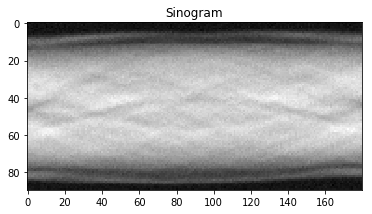

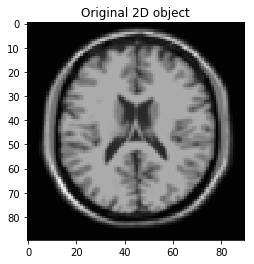

In [6]:
plt.figure()
plt.title("Sinogram")
plt.imshow(y_2D, cmap="gray")

plt.figure()
plt.title("Original 2D object")
plt.imshow(x_2D, cmap="gray")

## I-2 Optimization Problem 

We define the reconstructed image as the solution to the following optimization problem:

$(\forall x  \in \mathbb{R}^N) \quad f(x)=\frac{1}{2}||Hx - y||^2 + \lambda r(x)$

where $r$ is a regularization function incorporating a priori assumptions to
guarantee the robustness of the solution with respect to noise. In order to promote images formed by smooth regions separated by sharp edges, we set:

$r(x) = \sum^{2N}_{n=1} \psi ([Gx]^{(n)})$ and   $(\forall u \in \mathbb{R}) \quad \psi(u) = \sqrt{1 + u^2/\delta^2}$



$G\in \mathbb{R}^{2N \times N}$ is a sparse matrix computing discrete horizontal and vertical gradients of an image. 
$\psi$ is a differentiable convex potential, applied elementwise, which can be viewed as a smoothed version of the absolute value.

In [7]:
G = loadmat("data/G.mat")['G']

Parameters $(\lambda,\delta)$ have been finetuned to ensure an optimal image quality (i.e., minimizing quadratic reconstruction error).

In [8]:
delta = 0.05
lbd   = 0.3

$f$ is differentiable on $\mathbb{R}^N$. Its gradients reads:

$\nabla f(x) = H^THx - H^Ty + \lambda G^T\psi'(Gx)$
with $\forall u \in \mathbb{R} \quad \psi'(u) = \frac{1}{\delta^2}\frac{u}{\sqrt{1 + \frac{u^2}{\delta^2}}}$

Let us define useful functions for function/gradient evaluation:

In [9]:
def psi(x, delta=delta): 
    return np.sqrt(1 + np.square(x)/np.square(delta))

def psi_prime(x, delta=delta):
    return x / (np.square(delta) * psi(x))

def r(x):
    return psi(G.dot(x)).sum()

def grad_r(x):
    return G.T.dot(psi_prime(G.dot(x)))

def f(x):
    q = H.dot(x) - y
    return 0.5 * q.T.dot(q) + lbd * r(x)

def grad_f(x):
    return H.T.dot(H.dot(x) - y) + lbd * grad_r(x)

$f$ is Lipschitz differentiable on $\mathbb{R}^N$. The Lipschitz constant of $\nabla f$ is

$L = ||H||^2 + (\lambda / \delta^2)||G||^2$

It can be computed as:

In [10]:
# there is no norm 2 of matrix implemented with sparse matrix so we use a little trick to calculate it...
lipschitz_cst = scipy.sparse.linalg.svds(H)[1].max()**2 + (lbd / delta**2) * scipy.sparse.linalg.svds(G)[1].max()**2
print('Lipschitz constant = %.2f'%(lipschitz_cst))

Lipschitz constant = 18092.77


# II Comparison of optimization algorithms

Initialization of all algorithms:

In [13]:
x_0 = np.zeros_like(x)

## II-1 Gradient Descent Algorithm 

Let us start with the gradient descent method. We will use a constant stepsize, defined as follows:

In [16]:
nu = 1.999 / lipschitz_cst

In [17]:
def gradient_descent(f, grad_f, x_0, nu):
    
    x_n = x_0
    grad_fx = grad_f(x_n)
    sqr_norm_grad = grad_fx.T.dot(grad_fx)
    it = 0
    
    history = []
    t_0 = time.time()
    history.append([time.time() - t_0, f(x_n)])
    
    # criterion
    while sqr_norm_grad > N * 1e-8:
        it += 1
        
        # iteration
        x_n = x_n - nu * grad_fx
        
        grad_fx = grad_f(x_n)
        sqr_norm_grad = grad_fx.T.dot(grad_fx)
        if it % 250 == 0:
            print("it ",it,"sqr norm of grad:", sqr_norm_grad[0,0])
            history.append([time.time() - t_0, f(x_n)])
    
    history.append([time.time() - t_0, f(x_n)])
    print("Converged in ", str(it), " iterations")
    
    return x_n, np.array(history)

In [18]:
x_rec, history_gradient_descent = gradient_descent(f, grad_f, x_0, nu)

it  250 sqr norm of grad: 10695.982872611048
it  500 sqr norm of grad: 852.1122953706316
it  750 sqr norm of grad: 153.61664395305002
it  1000 sqr norm of grad: 38.823457218460355
it  1250 sqr norm of grad: 11.636000161738657
it  1500 sqr norm of grad: 3.878974471483368
it  1750 sqr norm of grad: 1.3833125125567958
it  2000 sqr norm of grad: 0.5180988497548122
it  2250 sqr norm of grad: 0.20194502399578051
it  2500 sqr norm of grad: 0.08138476773291385
it  2750 sqr norm of grad: 0.033722879027406394
it  3000 sqr norm of grad: 0.01430031190019378
it  3250 sqr norm of grad: 0.006182391631426786
it  3500 sqr norm of grad: 0.002716684984452983
it  3750 sqr norm of grad: 0.0012104223002435697
it  4000 sqr norm of grad: 0.000545747478912034
it  4250 sqr norm of grad: 0.0002485980001440132
it  4500 sqr norm of grad: 0.00011425256385925908
Converged in  4612  iterations


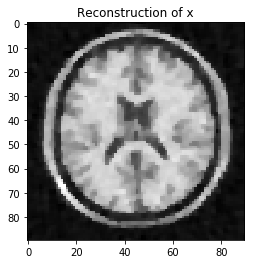

In [20]:
plt.figure()
plt.title("Reconstruction of x")
plt.imshow(x_rec.reshape(nx,nx,order='F'), cmap="gray")

## II-2 MM quadratic algorithm 

We now implement an MM quadratic algorithm wich consists on minimizing, at each iteration, a quadratic majorant of $f$ at the current iterate.

Let us construct a quadratic majorant of $f$:

Using the properties of the course, we can deduce that, at $x' \in \mathbb{R}^N$, 

$f(x) \leq q(x,x')$ with

$q(x,x') = f(x') + <\nabla f(x'),x-x'> + \frac{1}{2}||x-x_0||_{A(x')}$

The matrix $A(x')$ takes the form

$A(x') = H^TH + \lambda G^TD(G x') G$

with

$D(u) = \mathrm{Diag}(\frac{\psi'(u_{i})}{u_{i}})$



We define some functions that will be useful to evaluate the majorant function:

In [21]:
# the diagonal matrix for the regularization function potential:
def D(x):
    x = G.dot(x)
    d = 1. / (delta ** 2 * np.sqrt(1 + (x/delta)**2))
    return scipy.sparse.diags(d[:,0]).tocsc()

In [22]:
# Returns a linear operator that does the computation of the curvature of the majorant matrix at some point
def majorant_curve_operator(x_0):
    D_x_0 = D(x_0)
    def linear_operator(x):
        return H.T.dot(H.dot(x)) + lbd * G.T.dot(D_x_0.dot(G.dot(x)))
    return LinearOperator((N,N), matvec=linear_operator, rmatvec=linear_operator)

We can then implement the standard MM Quadratic Algorithm

In [23]:
# we use the constructed functions to implement the following algorithm:
def mm_quadratic(f, grad_f, majorant_curve_operator, x_0, theta):
    x_n = x_0
    grad_fx = grad_f(x_n)
    sqr_norm_grad = grad_fx.T.dot(grad_fx)
    it = 0
    
    history = []
    t_0 = time.time()
    history.append([time.time() - t_0, f(x_n)])
    
    while sqr_norm_grad > N * 1e-8:
        it += 1
        
        # at each iteration solve the linear system instead of inverting the matrix:
        x_n = x_n - theta * bicg(majorant_curve_operator(x_n), grad_fx)[0].reshape(N,1)
        
        grad_fx = grad_f(x_n)
        sqr_norm_grad = grad_fx.T.dot(grad_fx)
        if it % 5 == 0:
            print("it ",it,"sqr norm of grad:", sqr_norm_grad[0,0])
            history.append([time.time() - t_0, f(x_n)])
    
    history.append([time.time() - t_0, f(x_n)])
    print("Converged in ", str(it), " iterations")
    
    return x_n, np.array(history)

In [24]:
x_rec, history_mm_quadratic = mm_quadratic(f, grad_f, majorant_curve_operator, x_0, 1.99)

it  5 sqr norm of grad: 4727.440760057238
it  10 sqr norm of grad: 254.02675754652978
it  15 sqr norm of grad: 29.055319639537014
it  20 sqr norm of grad: 4.806741263855145
it  25 sqr norm of grad: 1.021009604576437
it  30 sqr norm of grad: 0.2581543146790757
it  35 sqr norm of grad: 0.07339319380581313
it  40 sqr norm of grad: 0.02260423947066547
it  45 sqr norm of grad: 0.007369659023717522
it  50 sqr norm of grad: 0.0025067931651838846
it  55 sqr norm of grad: 0.0008813189358575759
it  60 sqr norm of grad: 0.00031825589551324145
it  65 sqr norm of grad: 0.00011753083069855779
Converged in  67  iterations


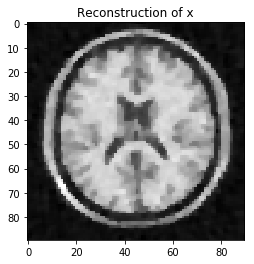

In [25]:
plt.figure()
plt.title("Reconstruction of x")
plt.imshow(x_rec.reshape(nx,nx,order='F'), cmap="gray")

## II-3 3MG algorithm 

We rebuild similar functions and algorithm, adding the subspace limitation on the defined operators.

In [26]:
def my_subspace_majorant_curv_matrix(x_0,dir_mat):
    D_x_0 = D(x_0)
    Gdir  = G.dot(dir_mat)
    Hdir  = H.dot(dir_mat)
    return Hdir.T.dot(Hdir) + lbd * Gdir.T.dot(D_x_0.dot(Gdir))

In [29]:
def three_mg_quadratic(f, grad_f, x_0):
    x_n = x_0
    x_n_minus_one = x_n
    grad_fx = grad_f(x_n)
    sqr_norm_grad = grad_fx.T.dot(grad_fx)
    it = 0
    
    history = []
    t_0 = time.time()
    history.append([time.time() - t_0, f(x_n)])
    
    while sqr_norm_grad > N * 1e-8:
        it += 1
        d1 = x_n - x_n_minus_one
        d2 = grad_fx
        dir_mat = np.concatenate((d1,d2),axis=1)
        x_n_minus_one = x_n
        
        # we solve the linear system on a limited subspace at each iteration:
        #x_n = x_n - dir_mat.dot(bicg(subspace_majorant_curve_operator(x_n, dir_mat), dir_mat.T.dot(grad_fx))[0].reshape(2,1))
        x_n = x_n - dir_mat.dot(scipy.linalg.pinv(my_subspace_majorant_curv_matrix(x_0,dir_mat))@dir_mat.T.dot(grad_fx))
        grad_fx = grad_f(x_n)
        sqr_norm_grad = grad_fx.T.dot(grad_fx)
        if it % 50 == 0:
            print("it ",it,"sqr norm of grad:", sqr_norm_grad[0,0])
            history.append([time.time() - t_0, f(x_n)])
    
    history.append([time.time() - t_0, f(x_n)])
    print("Converged in ", str(it), " iterations")
    
    return x_n, np.array(history)

In [30]:
x_rec, history_three_mg_quadratic = three_mg_quadratic(f, grad_f, x_0)

it  50 sqr norm of grad: 479.13397411390025
it  100 sqr norm of grad: 23.122900096163832
it  150 sqr norm of grad: 2.2957871068564115
it  200 sqr norm of grad: 0.3024410253942593
it  250 sqr norm of grad: 0.04704479611184517
it  300 sqr norm of grad: 0.008170434483899786
it  350 sqr norm of grad: 0.0015338564714084315
it  400 sqr norm of grad: 0.0003050569955474268
Converged in  443  iterations


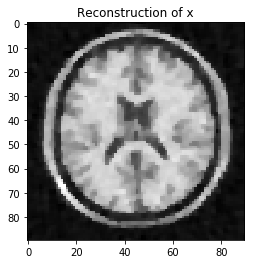

In [31]:
plt.figure()
plt.title("Reconstruction of x")
plt.imshow(x_rec.reshape(nx,nx,order='F'), cmap="gray")

## II-4 Parallel MM quadratic algorithm 

We finally implement a parallelizable version of the quadratic MM algorithm. One way to do this would be to find another majorant function, a "diagonal" majorant so that each term of the minimizer can be computed in parallel, independantly from the others, with no need of synchronization. Let us find $B$, such that $\forall x \in \mathbb{R}^N \quad A(x) \preceq B(x)$, with $B(x)$ diagonal.

Matrix $B(x)$ is constructed using Jensen's inequality.

We have, 
  
$ H^TH  \preceq Diag(\mathcal{h})$

with $\mathcal{h}_i = \sum_{m=1}^M |H_{mi}| \sum_{p=1}^N |H_{mp}|$

Similarly, for every $x' \in \mathbb{R}^N$,

$G^{T} D(G x')G \preceq Diag(\mathcal{g}(x'))$ 

with $\mathcal{g}_i(x') = \sum_{n=1}^{2N} \frac{\psi'(Gx')_{n}}{(Gx')_{n}} |G_{ni}| \sum_{p=1}^{n} |G_{np}|$

We finally obtain:

$
A(x') \preceq Diag(\mathcal{h}) + \lambda Diag(\mathcal{g}(x'))
$

In [32]:
H_diag = H.multiply(H.dot(np.ones((N,1)))).T.dot(np.ones((H.shape[0],1)))

In [33]:
G_diag = G.multiply(G.dot(np.ones((N,1))))

In [34]:
def b_diag_inverse(x):
    return scipy.sparse.diags(1./(H_diag + lbd * G_diag.T.dot(D(x).diagonal()))[0]).tocsc()

In [35]:
def mm_quadratic_parallel(f, grad_f, b_diag_inverse, x_0, theta):
    x_n = x_0
    grad_fx = grad_f(x_n)
    sqr_norm_grad = grad_fx.T.dot(grad_fx)
    it = 0
    
    history = []
    t_0 = time.time()
    history.append([time.time() - t_0, f(x_n)])
    
    while sqr_norm_grad > N * 1e-8:
        it += 1
        x_n = x_n - theta * b_diag_inverse(x_n).dot(grad_fx)       
        grad_fx = grad_f(x_n)
        sqr_norm_grad = grad_fx.T.dot(grad_fx)
        if it % 200 == 0:
            print("it ",it,"sqr norm of grad:", sqr_norm_grad[0,0])
            history.append([(time.time() - t_0)/32., f(x_n)])
    
    history.append([(time.time() - t_0)/32., f(x_n)])
    print("Converged in ", str(it), " iterations")
    
    return x_n, np.array(history)

Note that, in order to have an idea of the potential performance of the parallel algorithm, we consider that the computation is distributed on 32 workers and we neglect the overhead, so we will have a rough idea of the computational performance on a multicore architecture.

In [36]:
x_rec, history_mm_quadratic_parallel = mm_quadratic_parallel(f, grad_f, b_diag_inverse, x_0, 0.99)

it  200 sqr norm of grad: 2108.76920190274
it  400 sqr norm of grad: 123.25660003772957
it  600 sqr norm of grad: 16.057799281173736
it  800 sqr norm of grad: 2.8441601379931147
it  1000 sqr norm of grad: 0.5879339438023874
it  1200 sqr norm of grad: 0.13457305500493438
it  1400 sqr norm of grad: 0.03324993177401131
it  1600 sqr norm of grad: 0.008699979519793177
it  1800 sqr norm of grad: 0.002377373121728913
it  2000 sqr norm of grad: 0.0006718285492556624
it  2200 sqr norm of grad: 0.00019494794764590598
Converged in  2345  iterations


# III Comparison of the methods

We plot the evolution of the $f - f_{min}$ in function of time for the differents algorithms.

In [37]:
min_objective = np.min(history_gradient_descent[:,1])

ValueError: x and y must have same first dimension, but have shapes (10,) and (1, 10)

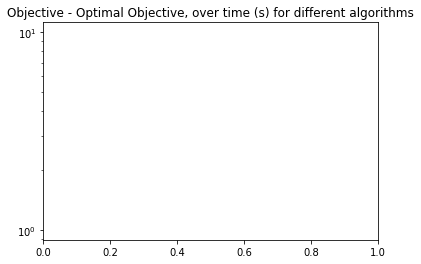

In [40]:
plt.figure()
plt.title("Objective - Optimal Objective, over time (s) for different algorithms")
plt.semilogy(history_three_mg_quadratic[:,0],history_three_mg_quadratic[:,1] - min_objective, label = "3MG quadratic")
plt.semilogy(history_mm_quadratic_parallel[:,0],history_mm_quadratic_parallel[:,1] - min_objective, label = "Parallel (32 workers)")
plt.semilogy(history_gradient_descent[:,0], history_gradient_descent[:,1] - min_objective, label = "gradient descent")
plt.semilogy(history_mm_quadratic[:,0],history_mm_quadratic[:,1] - min_objective, label = "MM quadratic")
plt.legend()

We see how much time it took to converge for the different algorithms.

In [39]:
print("With the given criteria, algorithms took the following time to converge:")
print("Gradient descent: {} s".format(int(history_gradient_descent[-1,0])))
print("MM quadratic: {} s".format(int(history_mm_quadratic[-1,0])))
print("3MG quadratic: {} s".format(int(history_three_mg_quadratic[-1,0])))
print("Parallel (32 workers): {} s".format(int(history_mm_quadratic_parallel[-1,0])))

With the given criteria, algorithms took the following time to converge:
Gradient descent: 41 s
MM quadratic: 36 s
3MG quadratic: 8 s
Parallel (32 workers): 22 s


# Bibliography

* A. Kak and M. Slaney, Principles of computerized tomographic imaging, Classics in Applied Mathematics. SIAM, Philadelphia, 1988.

* A. H. Delaney and Y. Bresler, “Globally convergent edge-preserving regularized reconstruction: an application to limited-angle tomography,” IEEE Transactions on Image Processing, vol. 7, no. 2, pp. 204 –221, Feb. 1998.

* E. Chouzenoux, F. Zolyniak, E. Gouillart and H. Talbot. A Majorize-Minimize Memory Gradient Algorithm Applied to X-Ray Tomography. In Proceedings of the 20th IEEE International Conference on Image Processing (ICIP 2013), pp. 1011-1015, Melbourne, Australia, 15-18 sep. 2013